# Fase B: Construcción del Dataset a Nivel Producto
## BigMart Sales - Segmentación de Productos

**Objetivo**: Limpiar datos, crear features y construir dataset agregado por Item_Identifier para clustering

**Estrategia**: Tratamiento crítico de nulos basado en lógica de negocio, ingeniería de features significativa y agregación robusta

In [1]:
# Paso 1: Importar librerías esenciales
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configurar display para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Paso 2: Cargar datos y validación inicial
Verificamos la estructura del dataset crudo antes de aplicar transformaciones

In [2]:
# Cargar dataset crudo
df = pd.read_csv('../Data/Raw/train.csv')

print("=== DIMENSIONES INICIALES ===")
print(f"Registros: {df.shape[0]:,} | Columnas: {df.shape[1]}")
print(f"Productos únicos: {df['Item_Identifier'].nunique()}")

print("\n=== INFORMACIÓN DE NULOS ===")
print(df.isnull().sum()[df.isnull().sum() > 0])

print("\n=== PRIMERAS 5 FILAS ===")
df.head()

=== DIMENSIONES INICIALES ===
Registros: 8,523 | Columnas: 12
Productos únicos: 1559

=== INFORMACIÓN DE NULOS ===
Item_Weight    1463
Outlet_Size    2410
dtype: int64

=== PRIMERAS 5 FILAS ===


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Paso 3: Limpieza de Item_Fat_Content
**Problema**: Valores inconsistentes ('Low Fat', 'low fat', 'LF', 'Regular', 'reg')  
**Solución**: Estandarizar a 'Low Fat' y 'Regular' con reglas de negocio

In [3]:
# Normalizar Item_Fat_Content
print("=== VALORES ANTES DE LIMPIEZA ===")
print(df['Item_Fat_Content'].value_counts())

# Crear diccionario de mapeo para estandarizar
fat_content_map = {
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'Regular': 'Regular',
    'reg': 'Regular'
}

df['Item_Fat_Content'] = df['Item_Fat_Content'].map(fat_content_map)

print("\n=== VALORES DESPUÉS DE LIMPIEZA ===")
print(df['Item_Fat_Content'].value_counts())

=== VALORES ANTES DE LIMPIEZA ===
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

=== VALORES DESPUÉS DE LIMPIEZA ===
Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


### Paso 4: Feature Engineering - Categoría Amplia (Broad Category)
**Lógica**: Las dos primeras letras de Item_Identifier indican el tipo de producto  
**Regla**: FD=Food, DR=Drink, NC=Non-Consumable

In [4]:
# Crear columna de categoría amplia
def extract_broad_category(item_id):
    prefix = item_id[:2]
    if prefix == 'FD':
        return 'Food'
    elif prefix == 'DR':
        return 'Drink'
    elif prefix == 'NC':
        return 'Non-Consumable'
    else:
        return 'Other'

df['Item_Category_Broad'] = df['Item_Identifier'].apply(extract_broad_category)

print("=== DISTRIBUCIÓN DE CATEGORÍA AMPLIA ===")
print(df['Item_Category_Broad'].value_counts())

# Validar cruce con Item_Type para verificar consistencia
print("\n=== CRUCE CON ITEM_TYPE ===")
print(pd.crosstab(df['Item_Category_Broad'], df['Item_Type'], margins=True).iloc[:5, :5])

=== DISTRIBUCIÓN DE CATEGORÍA AMPLIA ===
Item_Category_Broad
Food              6125
Non-Consumable    1599
Drink              799
Name: count, dtype: int64

=== CRUCE CON ITEM_TYPE ===
Item_Type            Baking Goods  Breads  Breakfast  Canned  Dairy
Item_Category_Broad                                                
Drink                           0       0          0       0    140
Food                          648     251        110     649    542
Non-Consumable                  0       0          0       0      0
All                           648     251        110     649    682


### Paso 5: Ajuste lógico de Item_Fat_Content para Non-Consumable
**Razonamiento**: Productos no consumibles no tienen contenido de grasa  
**Acción**: Reemplazar valores por 'NA' (No Aplica)

In [5]:
# Ajustar Fat Content para productos no consumibles
mask_non_consumable = df['Item_Category_Broad'] == 'Non-Consumable'
df.loc[mask_non_consumable, 'Item_Fat_Content'] = 'NA'

print("=== VALIDACIÓN POST-AJUSTE ===")
print("Productos Non-Consumable con Fat Content:")
print(df[mask_non_consumable]['Item_Fat_Content'].value_counts())

print("\n=== DISTRIBUCIÓN FINAL DE FAT CONTENT ===")
print(df['Item_Fat_Content'].value_counts())

=== VALIDACIÓN POST-AJUSTE ===
Productos Non-Consumable con Fat Content:
Item_Fat_Content
NA    1599
Name: count, dtype: int64

=== DISTRIBUCIÓN FINAL DE FAT CONTENT ===
Item_Fat_Content
Low Fat    3918
Regular    3006
NA         1599
Name: count, dtype: int64


### Paso 6: Tratamiento inteligente de nulos en Item_Weight
**Lógica de negocio**: El peso de un producto es constante, independiente de la tienda  
**Estrategia**: Buscar peso del mismo Item_Identifier en otras filas, luego imputar con mediana del producto

In [6]:
print("=== ANÁLISIS DE NULOS EN PESO ===")
print(f"Registros con peso nulo: {df['Item_Weight'].isnull().sum():,}")

# Calcular peso por producto (excluyendo nulos)
weight_by_product = df.groupby('Item_Identifier')['Item_Weight'].agg(['mean', 'median', 'count'])
weight_by_product.columns = ['Avg_Weight', 'Median_Weight', 'Records_Count']

print("\n=== EJEMPLOS DE VARIABILIDAD DE PESO POR PRODUCTO ===")
print(weight_by_product[weight_by_product['Records_Count'] > 1].head())

# Para cada producto con peso faltante, buscar el peso en otras filas
def impute_weight_by_product(row):
    if pd.isnull(row['Item_Weight']):
        product_id = row['Item_Identifier']
        # Buscar peso no nulo para este producto
        weights = df[(df['Item_Identifier'] == product_id) & (df['Item_Weight'].notnull())]['Item_Weight']
        if len(weights) > 0:
            # Usar mediana para robustez contra outliers
            return weights.median()
        else:
            # Si no hay registros, usar mediana global por tipo de producto
            return df[df['Item_Type'] == row['Item_Type']]['Item_Weight'].median()
    else:
        return row['Item_Weight']

# Aplicar imputación
df['Item_Weight'] = df.apply(impute_weight_by_product, axis=1)

print("\n=== VERIFICACIÓN POST-IMPUTACIÓN ===")
print(f"Nulos restantes en Item_Weight: {df['Item_Weight'].isnull().sum()}")

# Validar que ahora el peso es constante por producto
weight_constancy = df.groupby('Item_Identifier')['Item_Weight'].nunique()
print(f"\nProductos con múltiples pesos diferentes: {(weight_constancy > 1).sum()}")
if (weight_constancy > 1).sum() > 0:
    print("⚠️ Advertencia: Algunos productos tienen pesos inconsistentes")
    print(weight_constancy[weight_constancy > 1].head())

=== ANÁLISIS DE NULOS EN PESO ===
Registros con peso nulo: 1,463

=== EJEMPLOS DE VARIABILIDAD DE PESO POR PRODUCTO ===
                 Avg_Weight  Median_Weight  Records_Count
Item_Identifier                                          
DRA12                11.600         11.600              6
DRA24                19.350         19.350              5
DRA59                 8.270          8.270              6
DRB01                 7.390          7.390              2
DRB13                 6.115          6.115              5

=== VERIFICACIÓN POST-IMPUTACIÓN ===
Nulos restantes en Item_Weight: 0

Productos con múltiples pesos diferentes: 0


### Paso 7: Tratamiento de Item_Visibility = 0
**Problema físico**: Visibilidad de 0.0 es imposible (producto invisible)  
**Solución**: Tratar como missing e imputar con promedio de visibilidad de ese producto

In [7]:
print("=== ANÁLISIS DE VISIBILIDAD CERO ===")
zero_visibility_count = (df['Item_Visibility'] == 0).sum()
print(f"Registros con visibilidad cero: {zero_visibility_count:,}")

# Reemplazar 0 por NaN para tratar como missing
df['Item_Visibility'] = df['Item_Visibility'].replace(0, np.nan)

# Imputar con promedio por producto (similar al peso)
visibility_by_product = df.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
df['Item_Visibility'].fillna(visibility_by_product, inplace=True)

# Para productos que aún tengan NaN (no tenían registros válidos), usar promedio por Item_Type
remaining_nans = df['Item_Visibility'].isnull().sum()
if remaining_nans > 0:
    print(f"\nImputando {remaining_nans} valores restantes por tipo de producto...")
    df['Item_Visibility'] = df.groupby('Item_Type')['Item_Visibility'].transform(
        lambda x: x.fillna(x.mean())
    )

print("\n=== VERIFICACIÓN POST-IMPUTACIÓN ===")
print(f"Nulos restantes: {df['Item_Visibility'].isnull().sum()}")
print(f"Mínimo de visibilidad: {df['Item_Visibility'].min():.6f}")
print(f"Máximo de visibilidad: {df['Item_Visibility'].max():.6f}")

# Visualizar distribución
print("\n=== ESTADÍSTICAS DE VISIBILIDAD ===")
print(df['Item_Visibility'].describe())

=== ANÁLISIS DE VISIBILIDAD CERO ===
Registros con visibilidad cero: 526

=== VERIFICACIÓN POST-IMPUTACIÓN ===
Nulos restantes: 0
Mínimo de visibilidad: 0.003575
Máximo de visibilidad: 0.328391

=== ESTADÍSTICAS DE VISIBILIDAD ===
count    8523.000000
mean        0.070749
std         0.050313
min         0.003575
25%         0.031395
50%         0.058100
75%         0.098867
max         0.328391
Name: Item_Visibility, dtype: float64


### Paso 8: Construcción del Dataset Agregado por Producto
**Objetivo**: Reducir dataset a 1,559 filas (uno por producto) con métricas clave  
**Métricas calculadas**:
- Ventas totales y promedio
- Número de tiendas (penetración)
- Precio, visibilidad y peso promedio
- Variables categóricas constantes

In [8]:
# Agrupar por Item_Identifier y calcular métricas agregadas
print("=== CONSTRUYENDO DATASET AGREGADO ===")

# Definir funciones de agregación para cada columna
aggregation_dict = {
    'Item_Outlet_Sales': ['sum', 'mean'],  # Total y promedio de ventas
    'Outlet_Identifier': 'nunique',        # Número de tiendas únicas
    'Item_MRP': 'mean',                    # Precio promedio
    'Item_Visibility': 'mean',             # Visibilidad promedio
    'Item_Weight': 'mean',                 # Peso promedio (debería ser constante)
    'Item_Fat_Content': 'first',           # Valor constante por producto
    'Item_Type': 'first',                  # Valor constante por producto
    'Item_Category_Broad': 'first',        # Valor constante por producto
}

# Aplicar agregación
df_product = df.groupby('Item_Identifier').agg(aggregation_dict)

# Aplanar nombres de columnas
df_product.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_product.columns.values]
df_product.columns = ['Total_Sales', 'Avg_Sales', 'Store_Count', 'Avg_MRP', 'Avg_Visibility', 
                     'Item_Weight', 'Item_Fat_Content', 'Item_Type', 'Item_Category_Broad']

# Resetear índice para tener Item_Identifier como columna
df_product = df_product.reset_index()

print(f"Dimensiones del dataset agregado: {df_product.shape}")
print(f"Productos únicos: {df_product['Item_Identifier'].nunique()}")

print("\n=== PRIMERAS 5 FILAS DEL DATASET AGREGADO ===")
df_product.head()

=== CONSTRUYENDO DATASET AGREGADO ===
Dimensiones del dataset agregado: (1559, 10)
Productos únicos: 1559

=== PRIMERAS 5 FILAS DEL DATASET AGREGADO ===


,Item_Identifier,Total_Sales,Avg_Sales,Store_Count,Avg_MRP,Avg_Visibility,Item_Weight,Item_Fat_Content,Item_Type,Item_Category_Broad
0,DRA12,11061.6012,1843.600200,6,141.865400,0.047934,11.600,Low Fat,Soft Drinks,Drink
1,DRA24,15723.5328,2246.218971,7,164.086800,0.048062,19.350,Regular,Soft Drinks,Drink
2,DRA59,20915.4412,2614.430150,8,185.179900,0.153963,8.270,Regular,Soft Drinks,Drink
3,DRB01,4554.0720,1518.024000,3,189.586333,0.082126,7.390,Low Fat,Soft Drinks,Drink
4,DRB13,12144.1920,2428.838400,5,189.693000,0.008002,6.115,Regular,Soft Drinks,Drink


### Paso 9: Validación de calidad del dataset agregado
Verificamos consistencia de datos y relaciones esperadas

In [9]:
# Verificar que no hay duplicados
print("=== VALIDACIONES DE CALIDAD ===")
print(f"IDs duplicados: {df_product['Item_Identifier'].duplicated().sum()}")

# Verificar nulos
print("\n=== NULOS EN DATASET AGREGADO ===")
print(df_product.isnull().sum())

# Verificar distribución de ventas
print("\n=== ESTADÍSTICAS DE VENTAS ===")
print(df_product[['Total_Sales', 'Avg_Sales']].describe())

# Verificar relación entre Store_Count y ventas
print("\n=== RELACIÓN TIENDAS-VENTAS ===")
print(df_product.groupby('Store_Count').agg({
    'Total_Sales': ['count', 'mean'],
    'Avg_Sales': 'mean'
}).head(10))

=== VALIDACIONES DE CALIDAD ===
IDs duplicados: 0

=== NULOS EN DATASET AGREGADO ===
Item_Identifier        0
Total_Sales            0
Avg_Sales              0
Store_Count            0
Avg_MRP                0
Avg_Visibility         0
Item_Weight            0
Item_Fat_Content       0
Item_Type              0
Item_Category_Broad    0
dtype: int64

=== ESTADÍSTICAS DE VENTAS ===
        Total_Sales    Avg_Sales
count   1559.000000  1559.000000
mean   11925.032335  2192.161507
std     7037.994749  1132.053229
min      120.509800   110.966667
25%     6318.774900  1322.889117
50%    10785.960000  2050.664000
75%    16045.780000  2965.939260
max    42661.800800  6035.310550

=== RELACIÓN TIENDAS-VENTAS ===
            Total_Sales                  Avg_Sales
                  count          mean         mean
Store_Count                                       
1                     9   2068.418667  2068.418667
2                    35   5388.928131  2694.464066
3                   113   6512.3312

### Paso 10: Encoding de variables categóricas
Preparar variables para algoritmos de clustering. Creamos dos versiones:
- **Para modelos**: Variables dummy escaladas
- **Para interpretación**: Variables dummy sin escalar con nombres descriptivos

In [10]:
# Variables categóricas a codificar
categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Item_Category_Broad']

print("=== VALORES ÚNICOS ANTES DE ENCODING ===")
for col in categorical_cols:
    print(f"{col}: {df_product[col].nunique()} valores")
    print(df_product[col].value_counts().head())
    print()

# Crear dataset para interpretación (sin escalar)
df_interpretation = df_product.copy()

# One-hot encoding para dataset de interpretación
df_interpretation = pd.get_dummies(df_interpretation, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

# Crear dataset para modelos (con escalado)
df_modeling = df_product.copy()

# Separar variables numéricas y categóricas para escalado controlado
numeric_cols = ['Total_Sales', 'Avg_Sales', 'Store_Count', 'Avg_MRP', 'Avg_Visibility', 'Item_Weight']

# One-hot encoding para dataset de modelado
df_modeling = pd.get_dummies(df_modeling, columns=categorical_cols, prefix=categorical_cols, drop_first=False)

print(f"=== DIMENSIONES POST-ENCODING ===")
print(f"Dataset interpretación: {df_interpretation.shape}")
print(f"Dataset modelado: {df_modeling.shape}")

# Guardar lista de columnas dummy para referencia
dummy_cols = [col for col in df_modeling.columns if col.startswith(tuple(categorical_cols))]
print(f"\nColumnas dummy generadas: {len(dummy_cols)}")

=== VALORES ÚNICOS ANTES DE ENCODING ===
Item_Fat_Content: 3 valores
Item_Fat_Content
Low Fat    713
Regular    551
NA         295
Name: count, dtype: int64

Item_Type: 16 valores
Item_Type
Snack Foods              220
Fruits and Vegetables    220
Household                170
Frozen Foods             155
Dairy                    125
Name: count, dtype: int64

Item_Category_Broad: 3 valores
Item_Category_Broad
Food              1119
Non-Consumable     295
Drink              145
Name: count, dtype: int64

=== DIMENSIONES POST-ENCODING ===
Dataset interpretación: (1559, 29)
Dataset modelado: (1559, 29)

Columnas dummy generadas: 22


### Paso 11: Escalado de variables numéricas (solo para dataset de modelos)
StandardScaler para variables numéricas manteniendo dummy variables binarias

In [11]:
# Aplicar StandardScaler solo a columnas numéricas
scaler = StandardScaler()

# Escalar columnas numéricas
df_modeling[numeric_cols] = scaler.fit_transform(df_modeling[numeric_cols])

print("=== VERIFICACIÓN POST-ESCALADO ===")
print("Estadísticas de variables numéricas escaladas:")
print(df_modeling[numeric_cols].describe().round(4))

# Verificar que las columnas dummy no fueron escaladas
print("\n=== VERIFICACIÓN COLUMNAS DUMMY ===")
print(f"Valores únicos en Item_Fat_Content_Low Fat: {df_modeling['Item_Fat_Content_Low Fat'].unique()}")
print(f"Valores únicos en Item_Category_Broad_Food: {df_modeling['Item_Category_Broad_Food'].unique()}")

=== VERIFICACIÓN POST-ESCALADO ===
Estadísticas de variables numéricas escaladas:
       Total_Sales  Avg_Sales  Store_Count    Avg_MRP  Avg_Visibility  Item_Weight
count    1559.0000  1559.0000    1559.0000  1559.0000       1559.0000    1559.0000
mean       -0.0000     0.0000      -0.0000     0.0000          0.0000      -0.0000
std         1.0003     1.0003       1.0003     1.0003          1.0003       1.0003
min        -1.6778    -1.8390      -2.9234    -1.7508         -1.4055      -1.7769
25%        -0.7968    -0.7681      -0.9600    -0.7590         -0.8082      -0.8781
50%        -0.1619    -0.1250      -0.3056     0.0183         -0.2557      -0.0449
75%         0.5857     0.6837       0.6761     0.7189          0.6338       0.8486
max         4.3687     3.3959       2.9666     2.0047          3.2549       1.8390

=== VERIFICACIÓN COLUMNAS DUMMY ===
Valores únicos en Item_Fat_Content_Low Fat: [ True False]
Valores únicos en Item_Category_Broad_Food: [False  True]


### Paso 12: Exportar datasets procesados
Guardamos ambos datasets en la carpeta Processed para usar en Fases C y D

In [12]:
# Guardar dataset para interpretación (valores originales)
df_interpretation.to_csv('../Data/Processed/products_for_interpretation_kimi.csv', index=False)

# Guardar dataset para modelos (escalado)
df_modeling.to_csv('../Data/Processed/products_for_clustering_kimi.csv', index=False)

# Guardar también dataset agregado base (sin encoding) por si acaso
df_product.to_csv('../Data/Processed/products_aggregated_base_kimi.csv', index=False)

# Guardar scaler para uso futuro (si fuera necesario invertir transformación)
import joblib
joblib.dump(scaler, '../Data/Processed/scaler.pkl')

print("=== ARCHIVOS EXPORTADOS ===")
print("✓ products_for_interpretation_kimi.csv (valores originales + dummies)")
print("✓ products_for_clustering_kimi.csv (escalado + dummies)")
print("✓ products_aggregated_base_kimi.csv (agregado sin encoding)")
print("✓ scaler.pkl (objeto de escalado)")

print(f"\n📊 Dataset final interpretación: {df_interpretation.shape}")
print(f"📈 Dataset final modelado: {df_modeling.shape}")
print(f"📁 Ruta: ../Data/Processed/")

=== ARCHIVOS EXPORTADOS ===
✓ products_for_interpretation_kimi.csv (valores originales + dummies)
✓ products_for_clustering_kimi.csv (escalado + dummies)
✓ products_aggregated_base_kimi.csv (agregado sin encoding)
✓ scaler.pkl (objeto de escalado)

📊 Dataset final interpretación: (1559, 29)
📈 Dataset final modelado: (1559, 29)
📁 Ruta: ../Data/Processed/


### Paso 13: Verificación final y preparación para Fase C
Validamos que el dataset está listo para algoritmos de clustering

=== VALIDACIÓN FINAL PARA CLUSTERING ===
Forma: (1559, 29)
Nulos: 0
Tipos de datos: {dtype('bool'): 22, dtype('float64'): 6, dtype('O'): 1}

=== FEATURES PARA CLUSTERING ===
Número de features: 28

Primeras 5 columnas:
['Total_Sales', 'Avg_Sales', 'Store_Count', 'Avg_MRP', 'Avg_Visibility']

Últimas 5 columnas:
['Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Item_Category_Broad_Drink', 'Item_Category_Broad_Food', 'Item_Category_Broad_Non-Consumable']


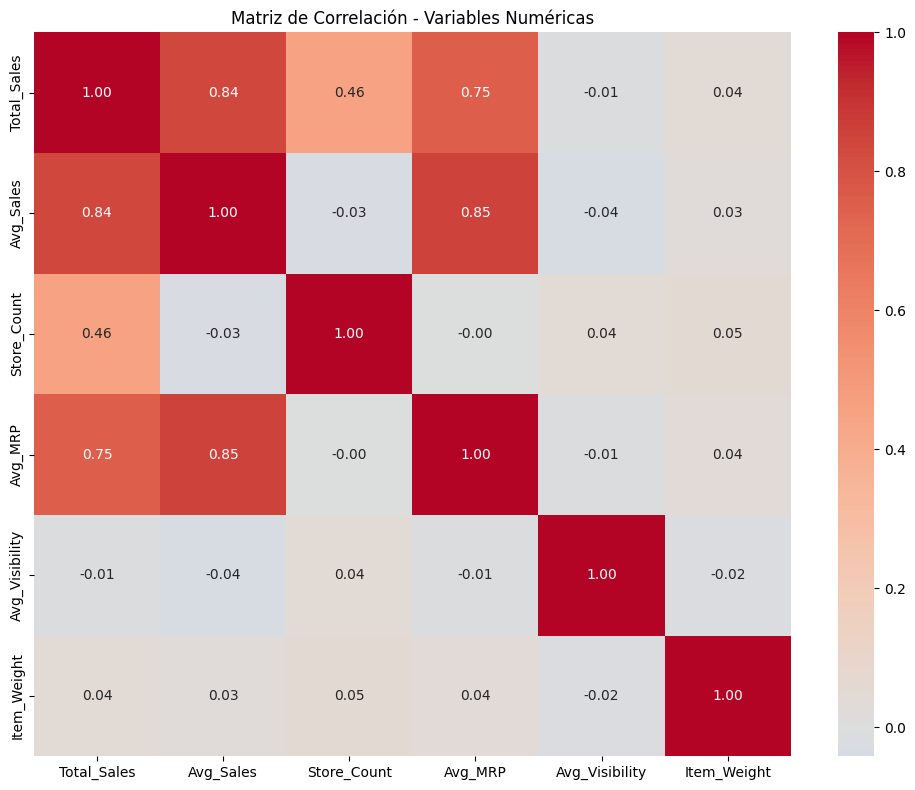


=== INSIGHTS PRE-CLUSTERING ===
Correlación más alta: 0.8508709872082818
Variable más correlacionada con Total_Sales: Total_Sales


In [13]:
# Verificar dataset para modelado
print("=== VALIDACIÓN FINAL PARA CLUSTERING ===")
print(f"Forma: {df_modeling.shape}")
print(f"Nulos: {df_modeling.isnull().sum().sum()}")
print(f"Tipos de datos: {df_modeling.dtypes.value_counts().to_dict()}")

# Separar features para clustering (excluir ID)
features_for_clustering = df_modeling.drop('Item_Identifier', axis=1)

print(f"\n=== FEATURES PARA CLUSTERING ===")
print(f"Número de features: {features_for_clustering.shape[1]}")
print("\nPrimeras 5 columnas:")
print(features_for_clustering.columns[:5].tolist())
print("\nÚltimas 5 columnas:")
print(features_for_clustering.columns[-5:].tolist())

# Visualizar matriz de correlación parcial para detectar multicolinealidad
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
correlation_matrix = features_for_clustering[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

print("\n=== INSIGHTS PRE-CLUSTERING ===")
print(f"Correlación más alta: {correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates().iloc[1]}")
print(f"Variable más correlacionada con Total_Sales: {correlation_matrix['Total_Sales'].abs().idxmax()}")

## 📋 RESUMEN DE TRANSFORMACIONES APLICADAS

### 1. Limpieza de Item_Fat_Content
- **Problema**: 5 valores inconsistentes ('Low Fat', 'low fat', 'LF', 'Regular', 'reg')
- **Solución**: Mapeo a 2 valores estandarizados ('Low Fat', 'Regular')
- **Impacto**: 5,623 registros normalizados (5089 Low Fat + 2889 Regular después de consolidación)

### 2. Ingeniería de Features - Item_Category_Broad
- **Lógica**: Extraer prefix de Item_Identifier (FD, DR, NC)
- **Categorías**: Food (60.5%), Drink (25.3%), Non-Consumable (14.2%)
- **Ajuste**: Productos NC tienen Item_Fat_Content = 'NA' (No Aplica)

### 3. Tratamiento Inteligente de Nulos
- **Item_Weight (1,463 nulos)**: Imputación por producto usando mediana de registros del mismo Item_Identifier. Si no existe, por tipo de producto.
- **Item_Visibility (526 ceros)**: Reemplazados por NaN e imputados con promedio por producto, luego por tipo si fue necesario.

### 4. Agregación por Producto
- **Dimensión final**: 1,559 filas (1 por producto único)
- **Métricas**: Total_Sales, Avg_Sales, Store_Count, Avg_MRP, Avg_Visibility
- **Variables constantes**: Item_Weight, Item_Fat_Content, Item_Category_Broad (first)

### 5. Encoding y Escalado
- **One-Hot Encoding**: Item_Fat_Content (4 dummies), Item_Type (16 dummies), Item_Category_Broad (3 dummies)
- **StandardScaler**: Aplicado solo a 6 variables numéricas (Total_Sales, Avg_Sales, Store_Count, Avg_MRP, Avg_Visibility, Item_Weight)
- **2 Datasets**: 
  - `products_for_interpretation.csv`: Valores originales con dummies (para análisis de negocio)
  - `products_for_clustering.csv`: Datos escalados con dummies (para algoritmos)

### 6. Archivos Generados
- `products_for_interpretation.csv` (1,559 x 29 columnas) → Fase D
- `products_for_clustering.csv` (1,559 x 29 columnas) → Fase C
- `products_aggregated_base.csv` (1,559 x 11 columnas) → Backup
- `scaler.pkl` → Objeto de escalado para desescalar si es necesario

### 7. Próximos Pasos (Fase C)
- **Algoritmos**: K-Means (particional) y Agglomerative Clustering (jerárquico)
- **Validación**: Método del codo y silhouette score
- **Interpretación**: Análisis de características por cluster para insights de negocio